In [277]:
import pandas as pd
import numpy as np
import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import category_encoders as ce
from sklearn.utils import resample

In [278]:
df = pd.read_csv('train.csv', nrows=100000)
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [279]:
# locate NA values
df.isna().sum()

date_time                        0
site_name                        0
posa_continent                   0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    36922
user_id                          0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                         71
srch_co                         71
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
dtype: int64

In [280]:
# too many NA's to keep
del df['orig_destination_distance']

In [281]:
# remove rows containing NA
df = df[df['srch_ci'].notna()]
df = df[df['srch_co'].notna()]

In [282]:
# check dtypes
df.dtypes

date_time                   object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                     object
srch_co                     object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
hotel_cluster                int64
dtype: object

In [283]:
# convert to date time
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [284]:
# what is this
df['srch_ci']

0        2014-08-27
1        2014-08-29
2        2014-08-29
3        2014-11-23
4        2014-11-23
            ...    
99995    2013-05-23
99996    2013-05-26
99997    2013-05-26
99998    2013-05-26
99999    2013-05-26
Name: srch_ci, Length: 99929, dtype: object

In [285]:
# convert to date time
df['srch_ci'] =  pd.to_datetime(df['srch_ci'], format='%Y-%m-%d')
df['srch_co'] =  pd.to_datetime(df['srch_co'], format='%Y-%m-%d')

In [286]:
# double check dtypes
df.dtypes

date_time                   datetime64[ns]
site_name                            int64
posa_continent                       int64
user_location_country                int64
user_location_region                 int64
user_location_city                   int64
user_id                              int64
is_mobile                            int64
is_package                           int64
channel                              int64
srch_ci                     datetime64[ns]
srch_co                     datetime64[ns]
srch_adults_cnt                      int64
srch_children_cnt                    int64
srch_rm_cnt                          int64
srch_destination_id                  int64
srch_destination_type_id             int64
is_booking                           int64
cnt                                  int64
hotel_continent                      int64
hotel_country                        int64
hotel_market                         int64
hotel_cluster                        int64
dtype: obje

In [287]:
# create useful data from date time formats
df['book_month'] = df['date_time'].dt.month
df['check_in_month'] = df['srch_ci'].dt.month
end = df['srch_co']
start = df['srch_ci']
df['length_stay'] = (end-start).dt.days

# remove date time features
del df['srch_ci']
del df['srch_co']
del df['date_time']

<AxesSubplot:xlabel='hotel_cluster', ylabel='count'>

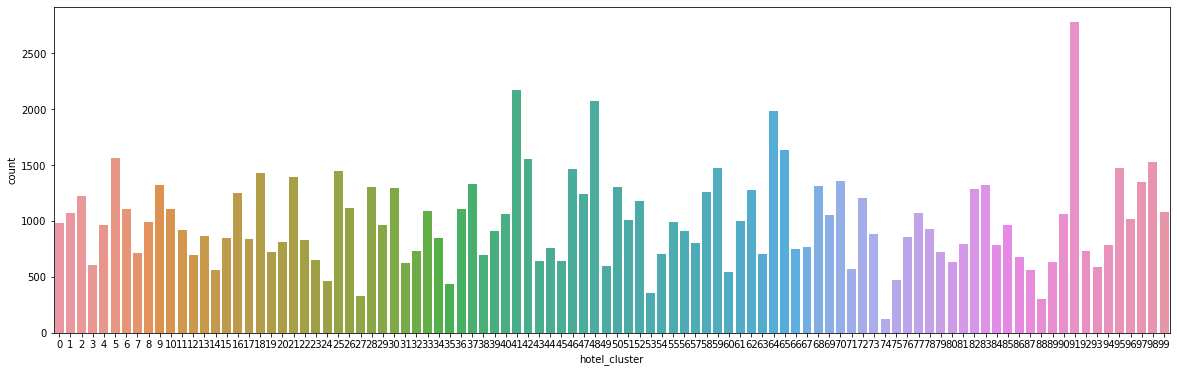

In [288]:
# check spread of clusters
plt.figure(figsize=(20, 6))
sns.countplot(x='hotel_cluster', data = df)

In [206]:
# remove unnecesary/redundant features
df = df[df['is_booking'] == 1]
del df['is_booking']
del df['user_location_city']
del df['user_id']
del df['srch_destination_id']
del df['user_location_region']
del df['hotel_continent']
del df['posa_continent']
del df['hotel_market']

df.head()

,site_name,user_location_country,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_type_id,cnt,hotel_country,hotel_cluster,book_month,check_in_month,length_stay
1,2,66,0,1,9,2,0,1,1,1,50,1,8,8,4
20,2,66,0,1,4,2,0,1,1,1,50,2,2,4,2
27,30,195,0,1,9,2,0,1,1,1,185,58,6,9,8
72,30,195,0,0,9,2,0,1,1,1,151,36,11,6,2
79,2,66,0,1,1,3,0,2,1,1,50,95,1,2,5


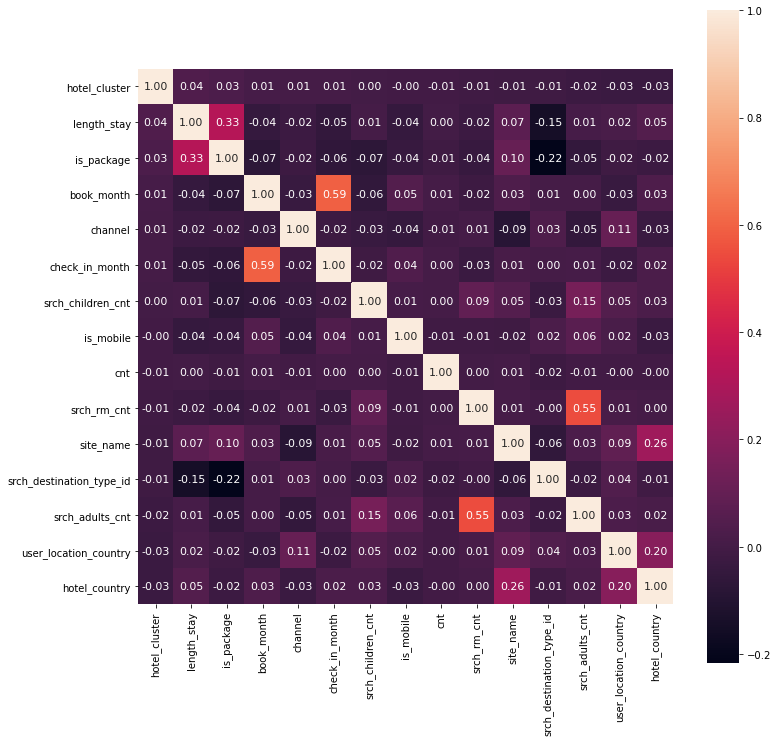

In [207]:
# check correlation map
corrmat = df.corr()
k = 15
plt.subplots(figsize=(12,12))

cols = corrmat.nlargest(k, 'hotel_cluster')['hotel_cluster'].index
cm = np.corrcoef(df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [208]:
# split target and non-target
X = df.drop(columns='hotel_cluster')
y = df['hotel_cluster']

In [253]:
# test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 11)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 11)


In [237]:
# create table to show model results
import time, math
from sklearn.metrics import accuracy_score
cols_results=['family','model','accuracy_rate']
results = pd.DataFrame(columns=cols_results)

In [238]:
# KNN model with simple tuning
from sklearn.neighbors import KNeighborsClassifier
kVals = range(1, 10)
knn_names = ['KNN-' + str(k) for k in kVals]
for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    results = results.append(pd.DataFrame([['KNN',knn_names[k-1],
                                            accuracy_score(y_test,y_pred)]],
                                          columns=cols_results),ignore_index=True)
results[results.family == 'KNN']

,family,model,accuracy_rate
0,KNN,KNN-1,0.102781
1,KNN,KNN-2,0.077993
2,KNN,KNN-3,0.073156
3,KNN,KNN-4,0.069528
4,KNN,KNN-5,0.062878
5,KNN,KNN-6,0.061669
6,KNN,KNN-7,0.057437
7,KNN,KNN-8,0.061064
8,KNN,KNN-9,0.061669


In [239]:
# random forest with simple tuning
from sklearn.ensemble import RandomForestClassifier
rVals = range(1, 4)
rf_names = ['RF-' + str(int(math.pow(10,r))) for r in rVals]
for r in rVals:
    clf = RandomForestClassifier(n_estimators=int(math.pow(10,r)),random_state=0)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    results = results.append(pd.DataFrame([['RF',rf_names[r-1],
                                            accuracy_score(y_test,y_pred)]],
                                          columns=cols_results),ignore_index=True)
    
results[results.family=='RF']

,family,model,accuracy_rate
9,RF,RF-10,0.095526
10,RF,RF-100,0.110036
11,RF,RF-1000,0.108827


In [296]:
# build basic RF model
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

from sklearn.metrics import accuracy_score
print('---Accuracy Scores---')
print('Training: {:6.2f}%'.format(100*rf.score(X_train, y_train)))
print('Validate: {:6.2f}%'.format(100*rf.score(X_val, y_val)))
print('Testing: {:6.2f}%'.format(100*rf.score(X_test, y_test)))


---Accuracy Scores---
Training:  88.83%
Validate:   9.14%
Testing:  10.10%


In [297]:
# Build RF grid search
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 25)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [298]:
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid,
                                n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1, scoring='accuracy')
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished


{'n_estimators': 481, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [302]:
# Tune model according to best params
rf = RandomForestClassifier(min_samples_split=2, max_depth=None, n_estimators=481,
                            min_samples_leaf=4, max_features='sqrt', bootstrap=True)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

print('---Accuracy Scores---')
print('Training: {:6.2f}%'.format(100*rf.score(X_train, y_train)))
print('Validate: {:6.2f}%'.format(100*rf.score(X_val, y_val)))
print('Testing: {:6.2f}%'.format(100*rf.score(X_test, y_test)))

---Accuracy Scores---
Training:  73.87%
Validate:   9.59%
Testing:  10.94%
